In [1]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.core import Activation, Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.datasets import mnist
from keras.utils import np_utils
from keras.optimizers import SGD, RMSprop, Adam
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.engine.topology import Layer, InputSpec
from keras.layers import Input, Permute,  Reshape,  Lambda, Concatenate
from keras.layers.merge import concatenate
from keras.models import Model
from keras.layers.recurrent import LSTM
from keras.layers.wrappers import Bidirectional, TimeDistributed
from keras.layers import merge, Multiply


SINGLE_ATTENTION_VECTOR = False


def attention_conv_block(inputs,timesteps):
    varsVec=[]
    for x in range(0,inputs.shape[2]):
            var=Lambda(lambda element : element[:,:,x])(inputs)
            var=contxt_padded = Lambda(lambda x: K.expand_dims(x,2))(var)
            var = Conv1D(filters=5 ,kernel_size=3,strides=1,padding='same',name='conv2_%d' % x)(var)
            var = Conv1D(filters=1 ,kernel_size=3,strides=1,padding='same',activation='softmax',name='conv_final_softmax_%d' % x)(var)
            varsVec.append(var)
    
    merged = concatenate(varsVec)
    output_attention_mul= Multiply()([inputs, merged])
    return output_attention_mul


class LSTMATTBFnet:
    @staticmethod
    def build(timeSteps,variables,classes):
        inputNet = Input(shape=(timeSteps,variables)) #batch_shape=(20, 7, 5) 
        #attBlock=attention_conv_block(inputNet,timeSteps)
        #lstm=Bidirectional(LSTM(100,recurrent_dropout=0.4,dropout=0.4),merge_mode='concat')(inputNet) #worse using stateful=True
        lstm=Bidirectional(LSTM(100,recurrent_dropout=0.1,dropout=0.1,return_sequences=False),merge_mode='concat')(inputNet) #worse using stateful=True 
        
        # a softmax classifier
        classificationLayer=Dense(classes,activation='softmax')(lstm)
        
        model=Model(inputNet,classificationLayer)
        return model


In [3]:
# load data
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
#from sklearn.cross_validation import train_test_split

def non_shuffling_train_test_split(X, y, test_size=0.2):
    i = int((1 - test_size) * X.shape[0]) + 1
    X_train, X_test = np.split(X, [i])
    y_train, y_test = np.split(y, [i])
    return X_train, X_test, y_train, y_test

# load all data
#dfin = pd.read_csv('windows-size72-step12.csv',header=None)  #inputs 72 lines per sample
#dfout = pd.read_csv('out-class-size72-step12.csv',header=None)  #output classes 
#dfin = pd.read_csv('windows-size168-step12.csv',header=None)  #inputs 72 lines per sample
#dfout = pd.read_csv('out-class-size168-step12.csv',header=None)  #output classes 

dfin = pd.read_csv('windows-size168-step24-Normalized.csv',header=None)  #inputs 72 lines per sample
#dfout = pd.read_csv('out-value-avg-size168-step24.norm.csv',header=None)  #output classes 
dfout = pd.read_csv('out-class-size168-step24-norm.csv',header=None)  #output classes 

total_inputs,total_output = dfin.values.astype(np.float32),dfout.values.astype(np.float32)

total_output_class = dfout.values.astype(np.int32)
print(total_output_class.shape)
#train_inputs, test_inputs, train_output_class, test_output_class = non_shuffling_train_test_split(total_inputs, total_output_class, test_size=0.2)
print(total_output_class[-286:])

test_output_class=total_output_class[-286:]
print(test_output_class.shape)



# normalize
scaler = MinMaxScaler(feature_range=(0, 1))
total_inputs = scaler.fit_transform(total_inputs)

# every 72 lines is one input sample
total_inputs = np.reshape(total_inputs, (-1,168,8))
#total_inputs = np.reshape(total_inputs, (-1,7,24,8))

print("############# total shapes #############")
print(total_inputs.shape)
print(total_output.size)

train_inputs, test_inputs, train_output, test_output = non_shuffling_train_test_split(total_inputs, total_output, test_size=0.2)
print("############# train shapes #############")
print(train_inputs.shape)
print(train_output.shape)

print("############# test shapes #############")
print(test_inputs.shape)
print(test_output.shape)




(1432, 1)
[[3]
 [4]
 [3]
 [4]
 [3]
 [4]
 [3]
 [3]
 [3]
 [4]
 [2]
 [2]
 [3]
 [3]
 [4]
 [3]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [4]
 [3]
 [3]
 [3]
 [2]
 [4]
 [2]
 [3]
 [2]
 [4]
 [2]
 [2]
 [3]
 [3]
 [2]
 [3]
 [3]
 [3]
 [2]
 [3]
 [3]
 [2]
 [3]
 [3]
 [3]
 [2]
 [3]
 [3]
 [1]
 [3]
 [2]
 [2]
 [1]
 [1]
 [2]
 [2]
 [2]
 [2]
 [3]
 [2]
 [2]
 [2]
 [3]
 [3]
 [2]
 [2]
 [1]
 [2]
 [2]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [4]
 [2]
 [2]
 [3]
 [1]
 [2]
 [2]
 [2]
 [2]
 [2]
 [4]
 [2]
 [3]
 [3]
 [4]
 [2]
 [2]
 [2]
 [1]
 [1]
 [4]
 [2]
 [1]
 [1]
 [1]
 [1]
 [2]
 [4]
 [3]
 [1]
 [1]
 [0]
 [1]
 [2]
 [4]
 [3]
 [0]
 [1]
 [2]
 [1]
 [2]
 [3]
 [3]
 [1]
 [1]
 [3]
 [0]
 [1]
 [2]
 [3]
 [2]
 [2]
 [2]
 [0]
 [0]
 [0]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [2]
 [2]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [4]
 [2]


In [4]:

IMG_ROWS, IMG_COLS = 168, 8 # input image dimensions
NB_CLASSES = 5  # number of outputs = number of classes

X_train = train_inputs
y_train = np_utils.to_categorical(train_output, NB_CLASSES)
X_test = test_inputs
y_test = np_utils.to_categorical(test_output, NB_CLASSES)
print(y_test.shape)

OPTIMIZER = Adam()

model = LSTMATTBFnet.build(timeSteps=168,variables=8,classes=5)
model.compile(loss="categorical_crossentropy", optimizer=OPTIMIZER,
	metrics=["accuracy"])

model.summary()


(286, 5)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 168, 8)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               87200     
_________________________________________________________________
dense (Dense)                (None, 5)                 1005      
Total params: 88,205
Trainable params: 88,205
Non-trainable params: 0
_________________________________________________________________


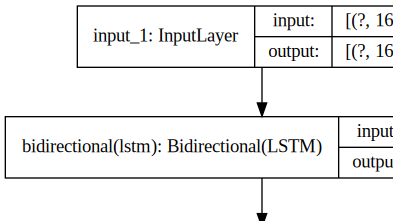

In [5]:
from IPython.display import SVG,display
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import matplotlib.pyplot as plt

modelSVG=SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))
display(modelSVG)
plot_model(model, to_file='model-att-conv1d.pdf',show_shapes=True)


In [6]:
NB_EPOCH = 100
BATCH_SIZE = 64
VERBOSE = 1

#tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)
#esCallBack = EarlyStopping(monitor='val_acc', min_delta=0, patience=12, verbose=0, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01,patience=5, min_lr=0.0001)
best_checkpoint = ModelCheckpoint('LSTM-energie.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
		batch_size=BATCH_SIZE, epochs=NB_EPOCH, 
		verbose=1, # 0 for no logging to stdout, 1 for progress bar logging, 2 for one log line per epoch.
		validation_data=(X_test,y_test),
		#validation_split=VALIDATION_SPLIT,
		callbacks=[reduce_lr,best_checkpoint])

Epoch 1/100
18/18 [==============================] - ETA: 0s - loss: 1.5489 - accuracy: 0.2679
Epoch 00001: val_accuracy improved from -inf to 0.24476, saving model to LSTM-energie.h5
18/18 [==============================] - 19s 1s/step - loss: 1.5489 - accuracy: 0.2679 - val_loss: 1.5282 - val_accuracy: 0.2448
Epoch 2/100
18/18 [==============================] - ETA: 0s - loss: 1.3681 - accuracy: 0.3813
Epoch 00002: val_accuracy improved from 0.24476 to 0.38462, saving model to LSTM-energie.h5
18/18 [==============================] - 20s 1s/step - loss: 1.3681 - accuracy: 0.3813 - val_loss: 1.3824 - val_accuracy: 0.3846
Epoch 3/100
18/18 [==============================] - ETA: 0s - loss: 1.3168 - accuracy: 0.4293
Epoch 00003: val_accuracy did not improve from 0.38462
18/18 [==============================] - 19s 1s/step - loss: 1.3168 - accuracy: 0.4293 - val_loss: 1.4040 - val_accuracy: 0.3217
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 1.3054 - accuracy: 0.41

In [7]:
import json,codecs
import numpy as np
def saveHist(path,history):
 
    new_hist = {}
    for key in list(history.history.keys()):
        if type(history.history[key]) == np.ndarray:
            new_hist[key] == history.history[key].tolist()
        elif type(history.history[key]) == list:
           #if  type(history.history[key][0]) == np.float64:
           new_hist[key] = list(map(float, history.history[key]))
 
    #print(new_hist)
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(new_hist, f, separators=(',', ':'), sort_keys=True, indent=4) 
 
def loadHist(path):
    with codecs.open(path, 'r', encoding='utf-8') as f:
        n = json.loads(f.read())
    return n
 


saveHist('LSTM-energie.hist',history)
hist=loadHist('LSTM-energie.hist')




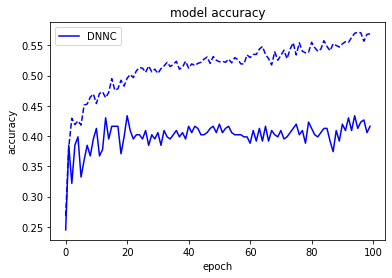

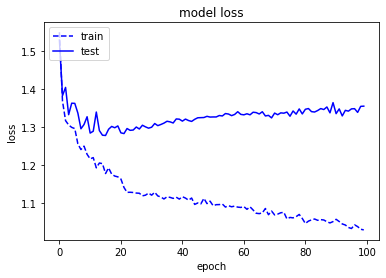

In [8]:
import matplotlib.pylab as plt

acc=np.array(hist['accuracy'])
#acc=acc[0:100]
#acc=np.append(acc,[0.7])
plt.plot(acc,'b--')
plt.plot(hist['val_accuracy'],'b',label='DNNC')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()
# summarize history for loss
loss=np.array(hist['loss'])
#loss=np.append(loss,[2])
plt.plot(loss,'b--',label='train')
plt.plot(hist['val_loss'],'b',label='test')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

from keras.models import load_model
model = load_model('LSTM-energie.h5')

print('Confusion Matrix')
cm=confusion_matrix(np.argmax(y_test,axis=1), np.argmax(model.predict(X_test),axis=1))
print(cm)
scores = model.evaluate(X_test,y_test, verbose=0)
print("Dados Validação %s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

pred = model.predict(X_test)
predicted = np.argmax(pred, axis=1)
report = classification_report(np.argmax(y_test, axis=1), predicted,digits=4)
print(report)

Confusion Matrix
[[32 14  5  1  3]
 [18 29 14  8  2]
 [ 1 21 32 11  8]
 [ 0  8 25 19  7]
 [ 1  2  6  7 12]]
Dados Validação accuracy: 43.36%
              precision    recall  f1-score   support

           0     0.6154    0.5818    0.5981        55
           1     0.3919    0.4085    0.4000        71
           2     0.3902    0.4384    0.4129        73
           3     0.4130    0.3220    0.3619        59
           4     0.3750    0.4286    0.4000        28

    accuracy                         0.4336       286
   macro avg     0.4371    0.4358    0.4346       286
weighted avg     0.4372    0.4336    0.4335       286



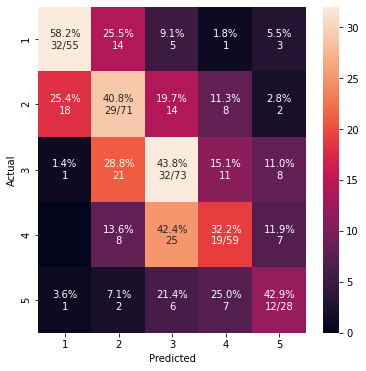

In [10]:
import seaborn as sns

def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    plt.savefig("LSTM-ATTENTION-CONV1D-AF-BIDIRECT-SPLIT-energie-CM.pdf")
    plt.show()
    
    
    
cm_analysis(np.argmax(y_test,axis=1),np.argmax(pred,axis=1), labels=["1","2","3","4","5"], ymap=None, figsize=(6,6))